In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf




In [2]:
df = pd.read_excel("archive/train_dataframes.xlsx")
df_test = pd.read_excel("archive/test_dataframes.xlsx")


df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df['month'] = df.index.month

#lags
lag_1, lag_24, lag_168 = [], [], []
df['lag_1'] = df['DEMAND'].shift(1)
df['lag_24'] = df['DEMAND'].shift(24)
df['lag_168'] = df['DEMAND'].shift(168)

# mean and std
df['roll_mean_6h']   = df['DEMAND'].rolling(window=6).mean()
df['roll_std_6h']    = df['DEMAND'].rolling(window=6).std()  #volatility
df['roll_mean_24h']  = df['DEMAND'].rolling(window=24).mean()
df['roll_std_24h']   = df['DEMAND'].rolling(window=24).std()
df['roll_mean_168h'] = df['DEMAND'].rolling(window=168).mean()
df['roll_std_168h']  = df['DEMAND'].rolling(window=168).std()

df.dropna(inplace=True)

# circle encoding bc 23 hr might seem farther than 0 but they are only 1 hr apart. model learns that end of cycle connects to start 
# Hour of day
df['hour_sin'] = np.sin(2 * np.pi * df['hourOfDay'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hourOfDay']/ 24)

# Month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Day of week
df['day_sin'] = np.sin(2 * np.pi * df['dayOfWeek'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['dayOfWeek'] / 7)



data = df[['hour_sin', 'hour_cos','day_sin','day_sin', 
           'week_X-2', 'week_X-3', 'week_X-4',
           'MA_X-4', 'weekend', 'Holiday_ID',
           'T2M_toc', 'month_sin','month_cos', 'DEMAND']].copy()

training_data_len = int(np.ceil(len(data)*0.95))









In [3]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)


In [ ]:
# LSTM model(predicts one step)
seq_len = 168
X_train, Y_train = [],[]
for i in range(168, len(scaled_data)):
    X_train.append(scaled_data[i-seq_len:i])
    Y_train.append(scaled_data[i,-1])
X_train = np.array(X_train) #(samples,168,5)
Y_train = np.array(Y_train)
X_train.shape , Y_train.shape
    

In [ ]:
model = keras.models.Sequential()
# 1st layer
model.add(keras.layers.LSTM(64, return_sequences = True, input_shape = (168,14)))
# 2nd layer
model.add(keras.layers.LSTM(64, return_sequences = False))
# 3rd layer
model.add(keras.layers.Dense(32, activation = "relu"))
# 4th layer
model.add(keras.layers.Dropout(0.5))
# final layer
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer = "adam",
            loss ="mse",   #mae treats all points equaly
            metrics = [keras.metrics.RootMeanSquaredError()])

training = model.fit(X_train,Y_train,epochs = 20
                    , batch_size = 64 , verbose=1)
    


In [ ]:
# ==== Prep test data ====
# Correctly get the target variable (Y_test) from the last column
test_data = scaled_data[training_data_len - seq_len:]
X_test, Y_test = [], []

for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i - seq_len:i])
    # FIX: Get Y_test from the last column (-1), not the first (0)
    Y_test.append(test_data[i, -1])

X_test = np.array(X_test)
Y_test = np.array(Y_test)

# ==== Predictions ====
predictions_scaled = model.predict(X_test)

# ==== Inverse transform ====
# Create empty arrays with same number of features for inverse scaling
Y_test_full = np.zeros((len(Y_test), scaled_data.shape[1]))
pred_full = np.zeros((len(predictions_scaled), scaled_data.shape[1]))

# FIX: Put target values into the LAST column (-1) for inverse scaling
Y_test_full[:, -1] = Y_test
pred_full[:, -1] = predictions_scaled[:, 0]

# FIX: Reverse scaling and get the result from the LAST column (-1)
Y_test_original = scaler.inverse_transform(Y_test_full)[:, -1]
predicted_demand = scaler.inverse_transform(pred_full)[:, -1]


# ==== Plotting ====
train = data[:training_data_len]
test = data[training_data_len:]
test = test.copy()
test['Predictions'] = predicted_demand

plt.figure(figsize=(12, 8))
# Note: Plotting test['DEMAND'] which is the original, unscaled value
plt.plot(test.index, test['DEMAND'], label='Test (actual)', color='green', alpha=0.8)
plt.plot(test.index, test['Predictions'], label='Predicted', color='orange')
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

# ==== Error metric ====
# This will now calculate correctly without a divide-by-zero error
mape = np.mean(np.abs((Y_test_original - predicted_demand) / Y_test_original)) * 100
print(f"📊 MAPE = {mape:.2f}%")

In [4]:
# Seq2Seq model

xtrain_s2s ,ytrain_s2s= [],[]
predict_len = 28
seq_len = 168
for t in range(seq_len,len(scaled_data) - predict_len):
    xtrain_s2s.append(scaled_data[t-seq_len:t])
    ytrain_s2s.append(scaled_data[t:t + predict_len, -1])

xtrain_s2s, ytrain_s2s = np.array(xtrain_s2s), np.array(ytrain_s2s)
xtrain_s2s.shape, ytrain_s2s.shape





((36356, 168, 14), (36356, 28))

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed


ytrain_s2s = ytrain_s2s.reshape(ytrain_s2s.shape[0], ytrain_s2s.shape[1], 1) # seq2seq expects 3D shape

# Get the shapes from the data
input_len = xtrain_s2s.shape[1]
num_features = xtrain_s2s.shape[2]
output_len = ytrain_s2s.shape[1]


# Define the model
model_s2s = Sequential()

# === Encoder ===
# Reads the input sequence and outputs a context vector (the final hidden state).
# return_sequences=False because we only need the final output.
model_s2s.add(LSTM(64,  input_shape=(input_len, num_features)))

# === Bridge ===
# Repeats the context vector 'output_len' times to prepare it for the decoder.
model_s2s.add(RepeatVector(output_len))

# === Decoder ===
# Reads the repeated context vector and generates the output sequence.
# return_sequences=True because we need an output for each of the 24 future steps.
model_s2s.add(LSTM(64,  return_sequences=True))

# === Final Output Layer ===
# The TimeDistributed layer applies a Dense layer to every single time step of the
# decoder's output. This gives us our final 24 predictions.
model_s2s.add(TimeDistributed(Dense(1)))


# Compile the model (same as before)
model_s2s.compile(optimizer='adam', loss='mse')
model_s2s.summary()

from sklearn.model_selection import train_test_split
# Split your data into 80% for training and 20% for validation
X_train, X_val, Y_train, Y_val = train_test_split(
    xtrain_s2s, ytrain_s2s, test_size=0.2, shuffle=False
)

from tensorflow.keras.callbacks import EarlyStopping

# This callback will stop training if the validation loss
# doesn't improve for 5 straight epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Now, update your .fit() call
training = model_s2s.fit(
    X_train, Y_train,
    epochs=100,  # Start with a larger number of epochs
    batch_size=128,
    # === Key Additions ===
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    # =====================
    verbose=1
)

2025-08-09 16:36:39.689254: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-08-09 16:36:39.689293: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-09 16:36:39.689302: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-09 16:36:39.689325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-09 16:36:39.689340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 28, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 28, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-08-09 16:36:40.843506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-08-09 16:36:40.846685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


228/228 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.1947 - val_loss: 0.0449
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0372 - val_loss: 0.0394
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0299 - val_loss: 0.0365
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0251 - val_loss: 0.0333
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0221 - val_loss: 0.0338
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0208 - val_loss: 0.0316
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0192 - val_loss: 0.0313
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0188 - val_loss: 0.0322
Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0185 - val_loss: 0.0296
Epoch 10/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0172 - val_loss: 0.0299
Epoch 11/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0161 - val_loss: 0.0299
Epoch 12/100
228/228 ━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


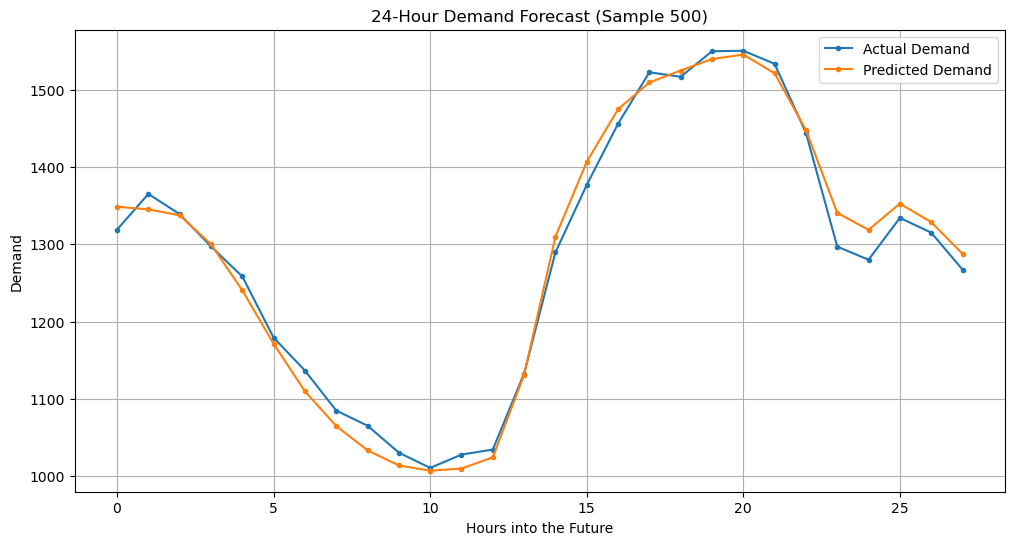

📊 MAPE = 2.31%


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Your trained Seq2Seq model
# model_s2s 

# Your original scaled data and scaler
# scaled_data
# scaler

# --- 1. Prepare the Test Set ---
# We'll use the same logic as your original notebook to define the test set.

training_data_len = int(np.ceil(len(data) * 0.95)) # Assuming 'data' is your pre-scaled DataFrame
test_data = scaled_data[training_data_len - input_len:]

# Create the sliding window for the test set
X_test, Y_test_scaled = [], []

for i in range(input_len, len(test_data) - output_len):
    X_test.append(test_data[i - input_len:i])
    Y_test_scaled.append(test_data[i:i + output_len, -1]) # Target is the last column

X_test, Y_test_scaled = np.array(X_test), np.array(Y_test_scaled)


# --- 2. Predict and Inverse Transform ---

# Get the scaled predictions from the model
predictions_scaled = model_s2s.predict(X_test)

# The scaler expects a 2D array, so we need to reshape our data.
# The model outputs (samples, 24, 1), we need (samples * 24, 1) to process.
num_samples = X_test.shape[0]
num_features = data.shape[1] # Your original number of features (e.g., 14)

# Create a placeholder array to hold the predictions for inverse transforming
# Shape: (number of total predicted steps, number of original features)
pred_placeholder = np.zeros((num_samples * output_len, num_features))

# Put the predictions into the last column of the placeholder
# We use .flatten() to make the 3D prediction array into a 1D list
pred_placeholder[:, -1] = predictions_scaled.flatten()

# Now, inverse transform the placeholder
predictions_unscaled = scaler.inverse_transform(pred_placeholder)[:, -1]

# Reshape back to the same shape as the predictions
predictions_unscaled = predictions_unscaled.reshape(num_samples, output_len)

# Do the same for the actual test values for comparison
actual_placeholder = np.zeros((num_samples * output_len, num_features))
actual_placeholder[:, -1] = Y_test_scaled.flatten()
Y_test_unscaled = scaler.inverse_transform(actual_placeholder)[:, -1]
Y_test_unscaled = Y_test_unscaled.reshape(num_samples, output_len)


# --- 3. Plot a Sample Forecast ---

# Let's pick a single sample from our test set to visualize the 24-hour forecast
sample_index = 500 # You can change this index to see different forecasts

plt.figure(figsize=(12, 6))
plt.plot(Y_test_unscaled[sample_index], label="Actual Demand", marker='.')
plt.plot(predictions_unscaled[sample_index], label="Predicted Demand", marker='.')
plt.title(f"24-Hour Demand Forecast (Sample {sample_index})")
plt.xlabel("Hours into the Future")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()
mape = np.mean(np.abs((Y_test_unscaled - predictions_unscaled) / Y_test_unscaled)) * 100
print(f"📊 MAPE = {mape:.2f}%")